### Baseline Building 
We are going to build a set of models and estimate their quality. The solution must be simple, it will be our baseline solution. Baseline is necessary because allows:
- Understand the approximate quality of a simple solution. Here we will apply mostly tested tools 
- Understand what type of model is better suitable for the task 
- Estimate the effectiveness of different data transformations 

As a baseline models we will use:
- Linear model (e.g. `sklearn.linear_model.RidgeClassifier`)
- Tree model (e.g. `sklearn.ensemble.RandomForestClassifier`)
- Boosting Model (e.g. `sklearn.ensemble.GradientBoostingClassifier`)

We are going to use the same dataset but this time from Kaggle. The dataset will become less (18.3k observations and 10k observations for testing)

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn import svm

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, cross_validate

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

from tqdm.notebook import tqdm as log_progress

warnings.filterwarnings('ignore')

In [3]:
# Download Train Data
train_data = pd.read_csv('orange_small_churn_train_data.csv')
train_data

,ID,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,labels
0,0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,...,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,-1.0
1,1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,...,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN,-1.0
2,2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN,-1.0
3,3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,...,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,1.0
4,4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,...,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18294,18294,NaN,NaN,NaN,NaN,NaN,462.0,0.0,NaN,NaN,...,mErwEWL,LM8l689qOp,NaN,NaN,uWr3,RAYp,F2FyR07IdsN7I,NaN,NaN,-1.0
18295,18295,NaN,NaN,NaN,NaN,NaN,1603.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,kG3k,uWr3,ZI9m,ib5G6X1eUxUn6,am7c,NaN,1.0
18296,18296,NaN,NaN,NaN,NaN,NaN,1239.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,ELof,Qcbd,ZI9m,55YFVY9,am7c,NaN,-1.0
18297,18297,NaN,NaN,NaN,NaN,NaN,210.0,0.0,NaN,NaN,...,wg_DmEs,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1.0


In [4]:
# Set seed for reproducibility
SEED = 23

There are missing values for the target feate. Let's find out how many 

In [5]:
train_data['labels'].isna().sum()

1

In [6]:
# Only one missing value, drop it 
train_data.drop(index=18298, inplace=True)

### Data Preprocessing 

In [7]:
# Rename the target
train_data.rename(columns={'labels':'is_churn'}, inplace=True)

# Drop ID column
train_data.drop('ID', axis=1, inplace=True)

In [8]:
# Split the features (numeric/categorical)
num_features = train_data.iloc[:, :190]
cat_features = train_data.iloc[:, 190:-1]

There are features that consits of only missing values. Find them and drop.

In [9]:
# Create a suitable function for dropping columns that have only NaN values
def drop_nan_columns(df):    
    feat_to_drop = [feature for feature in df.columns if df[feature].isna().all()]

    print(f'Dropped {len(feat_to_drop)} Columns')
    df.drop(columns=feat_to_drop, axis=1, inplace=True)
    
# Drop these columns 
drop_nan_columns(num_features)
drop_nan_columns(cat_features)

Dropped 16 Columns
Dropped 2 Columns


Initial preprocessing is done. For now, we can proceed and deal with *categorical/numeric* features

### Baseline 
We are going to **process *categorical/numeric* features separately.** We have a lot of numeric features and not so many categorical. For this purpose, we have the following plan. Firstly, build a model with only numeric features and estimate the quality, then with only categorical and again test the model. Finally, combine them and get the final score.

### Numerci Features
We've already conducted the initial data analysis. For these features, we've measured the correlation (mathematical expectation difference for different classes). **The main problem was many missing values.** Apply imputation for a feature with a 90% missing value just doesn't make any sense. Dependencies are complicated especially taking into account class imbalance. The following solution is proposed:
- Look at NaN ratio for features and select features that don't exceed a certain threshold. Then apply imputation.

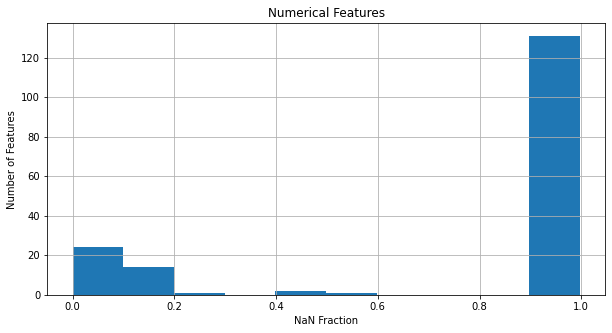

In [12]:
# Define a fucntion for plotting NaN ration 
def plot_nan_ration(df, figsize=(10,5), title='Numerical Features'):
    fig = plt.figure(figsize=figsize)
    plt.hist(df.iloc[:,:-1].isna().sum()/df.shape[0])
    plt.xlabel('NaN Fraction')
    plt.ylabel('Number of Features')
    plt.title(title)
    plt.grid();
    
plot_nan_ration(num_features)

We can observe from the graph above that there are 3 areas:
- NaN ratio `90~100%` (~ 140 features)
- NaN ratio `40~60%` (not many)
- NaN ratio `0~30%` (~35 features)

Since we are building a baseline solution we are not going to complicate it. 

Just **define 30% threshold** (i.e. features with more than 30% missing values are excluded from the research)

In [14]:
# Select features with NaN ratio less than 30%
temp_frame = num_features.isna().sum()/num_features.shape[0]
columns = temp_frame[temp_frame < 0.3].index

num_features = num_features[columns]

Next, we have to fill in missing values. The main options are:
- Fill with median/mean
- Use a model (e.g. KNN)
- Apply MICE algorithm

We will choose KNN as it seems more reliable

To prevent data leakage, we have to use `Pipeline` for more precise model estimation.

In [ ]:
# Define a suitable function for model cross-validation
def show_models_cv_pipeline(models, cv_type, x_train, y_train, metrics, is_aggregated=True):
    res_df = pd.DataFrame()
    
    for model in log_progress(models):
        model_pipeline = Pipeline([
            ('data_imputing', KNNImputer()),
            ('data_scaling', StandardScaler()),
            ('model', model)
        ])
    
        cv_results = cross_validate(model_pipeline, X=x_train, y=y_train, cv=cv_type, scoring=metrics)
        cv_results['Model'] = str(model).split('(')[0] # extract the current model name 
        res_df = res_df.append(pd.DataFrame(cv_results))
        
    # Make the first column model_name and  get rid of irrelevant columns
    new_columns_order = list(res_df.columns[2:-1])
    new_columns_order.insert(0, 'Model')
    
    # Returns aggregated/fold estimation 
    if is_aggregated:
        return res_df[new_columns_order].groupby(by='Model').mean()
    else:
        return res_df[new_columns_order]

In [17]:
# Matrix of features and labels
x_train = num_features
y_train = train_data['is_churn']

Baseline models:
- Random Forest
- Gradient Boosting
- Logistic Regression
- Ridge Classifier
- SVM Classifier

Since the dataset is imbalances, for each model we apply the following parameter:
- `class_weight='balanced'` 

In [18]:
%%time

# Main Models
models = [
    RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=SEED),
    GradientBoostingClassifier(random_state=SEED),
    LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=SEED, solver='liblinear', penalty='l1'),
    RidgeClassifier(class_weight='balanced', random_state=SEED),
    svm.SVC(class_weight='balanced', random_state=SEED)
]
  
# Cross-validation
cros_val_res = show_models_cv_pipeline(models=models,
                                       x_train=x_train,
                                       y_train=y_train,
                                       cv_type=StratifiedKFold(shuffle=True, random_state=SEED),
                                       metrics=['precision', 'recall', 'f1', 'roc_auc'],
                                       is_aggregated=True)
cros_val_res


Wall time: 16min 53s


,test_precision,test_recall,test_f1,test_roc_auc
Model,,,,
GradientBoostingClassifier,0.210714,0.003634,0.007108,0.689451
LogisticRegression,0.099658,0.631816,0.172155,0.614839
RandomForestClassifier,0.200000,0.000727,0.001449,0.645503
RidgeClassifier,0.099683,0.628891,0.172083,0.614684
SVC,0.109261,0.578097,0.183784,0.626358


Actually, it would be better to apply another method for imputing missing values because with KNN it takes much time.

It's important to have class balance. `GradientBoostingClassifier` doesn't have a parameter for class balancing and its estimation is a bit weird (good `ROC-AUC` but the rest metrics are bad)

The results are not bad. Let's look what quality we will get using categorical features.

### Categorical Features
Categorical features have many missing values as well.

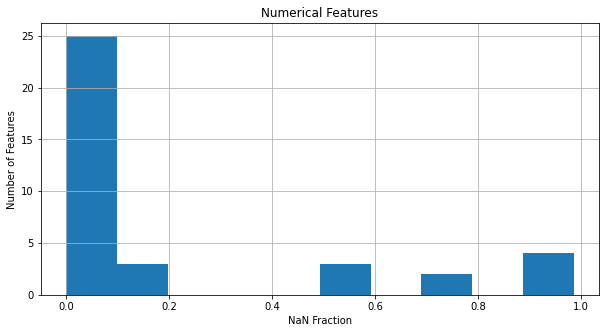

In [19]:
# NaN ration for categorical features
plot_nan_ration(cat_features)

We see several groups with different NaN ratio. let's apply a  20% threshold and select the features.

In [43]:
# Select features that have less than 20% missing values
temp_frame = cat_features.isna().sum()/cat_features.shape[0]
columns = temp_frame[temp_frame < 0.2].index

cat_features = cat_features[columns]

After selecting the features we can apply imputation. There are several options:
- Define a missing value as a new category `unknown`
- Fill missing values the most frequent category (mode)

As before we are using `Pipeline` with cross-validation

In [44]:
# Function for getting binary/categorical feature names
def return_bin_cat_columns(df):
    bin_columns = [feature for feature in df.columns if df[feature].value_counts().shape[0] == 2]
    cat_columns = df.columns.difference(bin_columns).to_list()
    
    return bin_columns, cat_columns

bin_columns, cat_columns = return_bin_cat_columns(cat_features)

We are going to process binary and categorical features separately. Add these stages in the `Pipeline`. For this purpose, use `ColumnTransformer`

In [45]:
# Pipeline Definition

# Binary features processing
binary_pipeline = Pipeline([
    ('binary_imputing', SimpleImputer(strategy='most_frequent')),
    ('binary_encoding', OrdinalEncoder())
])

# Categorical features processing
cat_pipeline = Pipeline([
    ('cat_imputing', SimpleImputer(strategy='most_frequent')),
    ('cat_encoding', OneHotEncoder(sparse=True, handle_unknown='ignore'))
])

# Combine transformations
transformations = [
    ('bin_transformations', binary_pipeline, bin_columns),
    ('cat_transformations', cat_pipeline, cat_columns)
]

cat_bin_transformations = ColumnTransformer(transformers=transformations)

In [42]:
%%time

# Modify the following function
def show_model_cvs_pipeline_cat_bin(models, cv_type, x_train, y_train, metrics, is_aggregated=True):
    res_df = pd.DataFrame()
    
    for model in log_progress(models):
        model_pipeline = Pipeline([
            ('cat_bin_transformations', cat_bin_transformations),
            ('model', model)
        ])
        
        cv_results = cross_validate(model_pipeline, X=x_train, y=y_train, cv=cv_type, scoring=metrics, error_score='raise')
        cv_results['Model'] = str(model).split('(')[0] 
        res_df = res_df.append(pd.DataFrame(cv_results))
        
    new_columns_order = list(res_df.columns[2:-1])
    new_columns_order.insert(0, 'Model')

    if is_aggregated:
        return res_df[new_columns_order].groupby(by='Model').mean()
    else:
        return res_df[new_columns_order]

# Cross-validate
cros_val_res = show_model_cvs_pipeline_cat_bin(models=models,
                                               x_train=cat_features,
                                               y_train=y_train,
                                               cv_type=StratifiedKFold(shuffle=True, random_state=SEED),
                                               metrics=['precision', 'recall', 'f1', 'roc_auc'],
                                               is_aggregated=True)
cros_val_res


Wall time: 4min 1s


,test_precision,test_recall,test_f1,test_roc_auc
Model,,,,
GradientBoostingClassifier,0.400000,0.001452,0.002893,0.641844
LogisticRegression,0.156809,0.255618,0.194326,0.627324
RandomForestClassifier,0.400000,0.001452,0.002893,0.601913
RidgeClassifier,0.058902,0.432835,0.103692,0.412177
SVC,0.177266,0.187349,0.182117,0.629111


Quality on only categorical features is less in comparison with numeric features. Now, let's combine all features and estimate the quality of the models.

In [46]:
# Add in the Pipeline Numeric features processing
num_columns = num_features.columns.to_list()

num_pipeline = Pipeline([
    ('data_imputing', KNNImputer()),
    ('data_scaling', StandardScaler())
])

# Combine the transformations
transformations = [
    ('num_transformations', num_pipeline, num_columns),
    ('bin_transformations', binary_pipeline, bin_columns),
    ('cat_transformations', cat_pipeline, cat_columns)
]

feature_transformations = ColumnTransformer(transformers=transformations)

In [47]:
# New matrix of features
x_train = pd.concat([num_features, cat_features], axis=1)

In [48]:
%%time

# Again modify the function 
def show_model_cvs_pipeline_all_features(models, cv_type, x_train, y_train, metrics, is_aggregated=True):
    res_df = pd.DataFrame()
    
    for model in log_progress(models):
        model_pipeline = Pipeline([
            ('feature_transformations', feature_transformations),
            ('model', model)
        ])
        
        cv_results = cross_validate(model_pipeline, X=x_train, y=y_train, cv=cv_type,
                                    scoring=metrics, error_score='raise', n_jobs=-1)
        
        cv_results['Model'] = str(model).split('(')[0] 
        res_df = res_df.append(pd.DataFrame(cv_results))
        
    new_columns_order = list(res_df.columns[2:-1])
    new_columns_order.insert(0, 'Model')
    
    if is_aggregated:
        return res_df[new_columns_order].groupby(by='Model').mean()
    else:
        return res_df[new_columns_order]

cros_val_res = show_model_cvs_pipeline_all_features(models=models,
                                                    x_train=x_train,
                                                    y_train=y_train,
                                                    cv_type=StratifiedKFold(shuffle=True, random_state=SEED),
                                                    metrics=['precision', 'recall', 'f1', 'roc_auc'],
                                                    is_aggregated=True)
cros_val_res


Wall time: 7min 13s


,test_precision,test_recall,test_f1,test_roc_auc
Model,,,,
GradientBoostingClassifier,0.322143,0.006543,0.012772,0.704115
LogisticRegression,0.158200,0.261423,0.197074,0.634839
RandomForestClassifier,0.000000,0.000000,0.000000,0.640363
RidgeClassifier,0.057995,0.426314,0.102100,0.408890
SVC,0.157182,0.287576,0.203215,0.654916


On all features quality is good. To get more details about the qulaity, look at each fold

In [49]:
cros_val_res = show_model_cvs_pipeline_all_features(models=models,
                                                    x_train=x_train,
                                                    y_train=y_train,
                                                    cv_type=StratifiedKFold(shuffle=True, random_state=SEED),
                                                    metrics=['precision', 'recall', 'f1', 'roc_auc'],
                                                    is_aggregated=False)
cros_val_res

,Model,test_precision,test_recall,test_f1,test_roc_auc
0,RandomForestClassifier,0.000000,0.000000,0.000000,0.648014
1,RandomForestClassifier,0.000000,0.000000,0.000000,0.633017
2,RandomForestClassifier,0.000000,0.000000,0.000000,0.646612
3,RandomForestClassifier,0.000000,0.000000,0.000000,0.639130
4,RandomForestClassifier,0.000000,0.000000,0.000000,0.635042
0,GradientBoostingClassifier,0.625000,0.018182,0.035336,0.722954
1,GradientBoostingClassifier,0.000000,0.000000,0.000000,0.699551
2,GradientBoostingClassifier,0.200000,0.003623,0.007117,0.689047
3,GradientBoostingClassifier,0.500000,0.003636,0.007220,0.717122
4,GradientBoostingClassifier,0.285714,0.007273,0.014184,0.691904


### Conclusion
The obtained quality is not bad and this is the baseline quality. Next, we are going to apply more precise feature selection and experiments with the features to improve the quality. We've also looked at the quality on each fold and can conclude that not all models are good at finding the `churn` class. `RandomForestClassifier` even with parameter `class_weight='balanced'` is bad at finding the `churn`.

**Random Forest**

Most of the time finds the majority class `not_churn`. On all 5 folds, it was finding only `not_churn`.

**Gradient Boosting**

A bit better, `precision` and `recall` are different from zero.

**Logistic Regression**

Not bad results in terms of `precision` and `recall`. However, `roc_auc` is lower in comparison with `Gradient Boosting`

**Ridge Classifier**
Poor metrics results, the worst model

Since the main metric of the competition is `ROC-AUC` we will consider this metric. We can conclude that the best model is `GradientBoostingClassifier`. Besides, tree models outperform linear ones.

### Baseline Quality on Test Data
Let's test *baseline* on kaggle.

In [ ]:
# Some functions
def to_submission(data, f_name):
    result = pd.DataFrame({'Id':range(data.shape[0]),
                           'result':data[:,1]})
    result.to_csv(f_name, index=False)

def make_submission_using_pipeline(models, x_train, y_train, x_test, f_names):
    
    predictions = []
    
    for model in log_progress(models):
        model_pipeline = Pipeline([
            ('feature_transformations', feature_transformations),
            ('model', model)
        ])
        model_pipeline.fit(x_train, y_train)
        predictions.append(model_pipeline.predict_proba(x_test))
        
    
    for indx, pred in enumerate(predictions):
        to_submission(pred, f_name=f_names[indx])

The results showed that the best models are:
- GradientBoostingClassifier
- SVC

Test them

In [59]:
# Test data loading 
test_data = pd.read_csv('orange_small_churn_test_data.csv')
x_test = test_data[x_train.columns]
x_test

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var226,Var227,Var228
0,1225.0,7.0,2352.0,180.0,225.0,0.0,56.0,388.08,0.0,6726960.0,...,jgOV,UYBR,FzaX,UF16siJ,zCkv,APgdzOv,jySVZNlOJy,xb3V,6fzt,Zy3gnGM
1,896.0,14.0,1560.0,112.0,140.0,0.0,96.0,133.12,0.0,0.0,...,PDRj,cJvF,FzaX,ot6oLzk,oslk,IIvC99a,LM8l689qOp,xb3V,RAYp,F2FyR07IdsN7I
2,791.0,7.0,2824.0,172.0,215.0,4.0,16.0,324.48,0.0,2988486.0,...,laMb,UYBR,FzaX,6VLNqhB,oslk,6YSocsg,LM8l689qOp,rgKb,RAYp,F2FyR07IdsN7I
3,2296.0,7.0,3732.0,480.0,600.0,10.0,104.0,286.96,0.0,6637740.0,...,qLRt,UYBR,FzaX,tzp8jNM,oslk,5nQ7A2G,jySVZNlOJy,rgKb,RAYp,F2FyR07IdsN7I
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,XqfQ,UYBR,FzaX,EPImS85,oslk,MI8s5nE,LM8l689qOp,7P5s,RAYp,F2FyR07IdsN7I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,714.0,7.0,2240.0,120.0,150.0,10.0,80.0,133.12,0.0,0.0,...,vawI,cJvF,Lmli,ch2oGfM,zCkv,P6pu4Vl,LM8l689qOp,xb3V,ZI9m,R4y5gQQWY8OodqDV
9996,812.0,7.0,2020.0,136.0,170.0,0.0,104.0,253.52,0.0,4147200.0,...,jQNd,cJvF,FzaX,8d5YWu3,oslk,sXbT3Cb,LM8l689qOp,WqMG,RAYp,55YFVY9
9997,819.0,7.0,40.0,120.0,150.0,0.0,56.0,321.28,0.0,1555200.0,...,g9B7,cJvF,FzaX,WdPoLzk,oslk,05jAV0N,M_8D,TNEC,RAYp,55YFVY9
9998,NaN,7.0,112.0,NaN,0.0,NaN,0.0,0.00,0.0,0.0,...,BCds,UYBR,FzaX,EMvv4zN,oslk,RDY7kpB,LM8l689qOp,uWr3,RAYp,55YFVY9


In [63]:
models = [
    GradientBoostingClassifier(random_state=SEED),
    svm.SVC(class_weight='balanced', random_state=SEED, probability=True)
]

make_submission_using_pipeline(models=models,
                               x_train=x_train,
                               y_train=y_train,
                               x_test=x_test,
                               f_names=['gb_pipeline_baseline.csv', 'svc_pipeline_baseline.csv'])

### Results 
- GradientBoostingClassifier (`0.68784`)
- SVC (`0.64952`)

Next we are going use as a main model `GradientBoostingClassifier`